In [18]:
import pandas as pd
import numpy as np
from plotnine import *

from binarymap import BinaryMap
import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import sys,os
import time

min_support_call = 2
var_thres = 0.5
libs = ['JN1lib1', 'JN1lib2']
bc_table = pd.read_csv("../data/DMS/JN1_barcode_variant_table.csv").query('variant_call_support >= @min_support_call and library in @libs')
df_libs = []

for lib in libs:
    df = pd.read_csv(f'../data/DMS/RBD_expression/{lib}/expr_meanF_variant_{lib}.csv').dropna(subset = ['delta_ML_meanF'])
    use_barcodes = set(bc_table['barcode'].to_list())
    df = df.query('barcode in @use_barcodes')

    df['aa_substitutions'] = df['aa_substitutions'].fillna('')
    df.rename(columns={'delta_ML_meanF':'func_score','var_ML_meanF':'func_score_var'},inplace=True)

    func_scores = df[pd.notnull(df['func_score'])].reset_index(drop=True).query('n_aa_substitutions > 0 and func_score_var < @var_thres')
    func_scores.fillna('',inplace=True)

    detected_muts = set()
    single_muts = set()

    for x in func_scores['aa_substitutions']:
        _ = x.split(' ')
        if (len(_) == 1):
            single_muts.add(x)
        for i in _:
            detected_muts.add(i)

    print(lib, "N_single:",len(single_muts), "N_detected:",len(detected_muts))
    df_libs.append(func_scores)

df_libs = pd.concat(df_libs)

JN1lib1 N_single: 3722 N_detected: 3988
JN1lib2 N_single: 3606 N_detected: 3989


In [19]:
single_mean = df_libs.query("n_aa_substitutions == 1").groupby(['library','aa_substitutions'])['func_score'].mean().reset_index().sort_values(['library', 'func_score'], ascending=False)
func_scores = df_libs
# func_scores = df_libs.query('(not aa_substitutions.str.contains("\*"))') # do not include stop variants when fitting the epistasis model

single_mean.head()

,library,aa_substitutions,func_score
4904,JN1lib2,H188P,0.494132
4748,JN1lib2,G171S,0.458966
6865,JN1lib2,V193P,0.440886
6343,JN1lib2,S125G,0.428972
4915,JN1lib2,H9D,0.396565


In [20]:
models = {} # this part follows the method from J. Bloom Lab

for (lib), scores in func_scores.groupby(['library']):
    print(len(scores))
    bmap = BinaryMap(scores)
    
    for epistasistype, likelihoodtype, Model in [
            # ('global epistasis', 'Gaussian', dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood),
            # ('no epistasis', 'Gaussian', dms_variants.globalepistasis.NoEpistasisGaussianLikelihood),
            ('global epistasis', 'Cauchy', dms_variants.globalepistasis.MonotonicSplineEpistasisCauchyLikelihood),
            ('no epistasis', 'Cauchy', dms_variants.globalepistasis.NoEpistasisCauchyLikelihood),
            ]:
        print(f"Fitting {epistasistype} with {likelihoodtype} likelihood model to {lib}...", end=' ')
    
        start = time.time()
        model = Model(bmap)
        model.fit()
        print(f"fitting took {time.time() - start:.1f} sec.")
        models[(epistasistype, likelihoodtype, lib)] = model

78772
Fitting global epistasis with Cauchy likelihood model to ('JN1lib1',)... fitting took 101.3 sec.
Fitting no epistasis with Cauchy likelihood model to ('JN1lib1',)... fitting took 1.7 sec.
57913
Fitting global epistasis with Cauchy likelihood model to ('JN1lib2',)... fitting took 118.6 sec.
Fitting no epistasis with Cauchy likelihood model to ('JN1lib2',)... fitting took 1.3 sec.


In [21]:
logliks_df = (
    pd.DataFrame.from_records(
            [(epistasistype, likelihoodtype, lib, model.nparams, model.loglik) for
             (epistasistype, likelihoodtype, (lib,)), model in models.items()],
            columns=['model', 'likelihood type', 'library',
                     'n_parameters', 'log_likelihood']
            )
    .assign(AIC=lambda x: 2 * x['n_parameters'] - 2 * x['log_likelihood'])
    .set_index(['library'])
    )

logliks_df.round(1)

,model,likelihood type,n_parameters,log_likelihood,AIC
library,,,,,
JN1lib1,global epistasis,Cauchy,3996,-86084.7,180161.4
JN1lib1,no epistasis,Cauchy,3990,-104135.2,216250.3
JN1lib2,global epistasis,Cauchy,3997,-52259.7,112513.3
JN1lib2,no epistasis,Cauchy,3991,-67217.1,142416.2


In [27]:
res_numbering_map = lambda x: x+330 if x < 153 else x+331 # deal with the 483del in JN.1
cutoff_low = -4

for lib in libs:
    output_df = models.get(('global epistasis', 'Cauchy', (lib,))).single_mut_effects(phenotype='observed',standardize_range=False).assign(
        library = lib).rename(columns={'effect':'expr_model', 'mutation':'mutation_st', 'mutant':'mutation'})

    output_df['site'] = [res_numbering_map(x) for x in output_df['site']]
    output_df['mutant'] = output_df['wildtype']+output_df['site'].astype(str)+output_df['mutation']
    output_df = (
        output_df.merge(single_mean, left_on=['library','mutation_st'], right_on=['library','aa_substitutions'], how='left')
                 .drop(columns='aa_substitutions').rename(columns={'func_score':'expr_single'})
                 .sort_values(['site','mutant']).reset_index(drop=True)
    )
    output_df['expr'] = [
        max(cutoff_low, (output_df['expr_single'][i] if not np.isnan(output_df['expr_single'][i]) else output_df['expr_model'][i])) for i in range(len(output_df))
    ]

    output_df.to_csv(f"../data/DMS/RBD_expression/{lib}/_single_mutation_effects.csv", index=None)


4196
4181
PearsonRResult(statistic=0.8739719096217007, pvalue=0.0)


/tmp/ipykernel_4488/987445333.py:15: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/gshare/xielab/jianfc/miniforge3/envs/antibody/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 15 rows containing missing values.


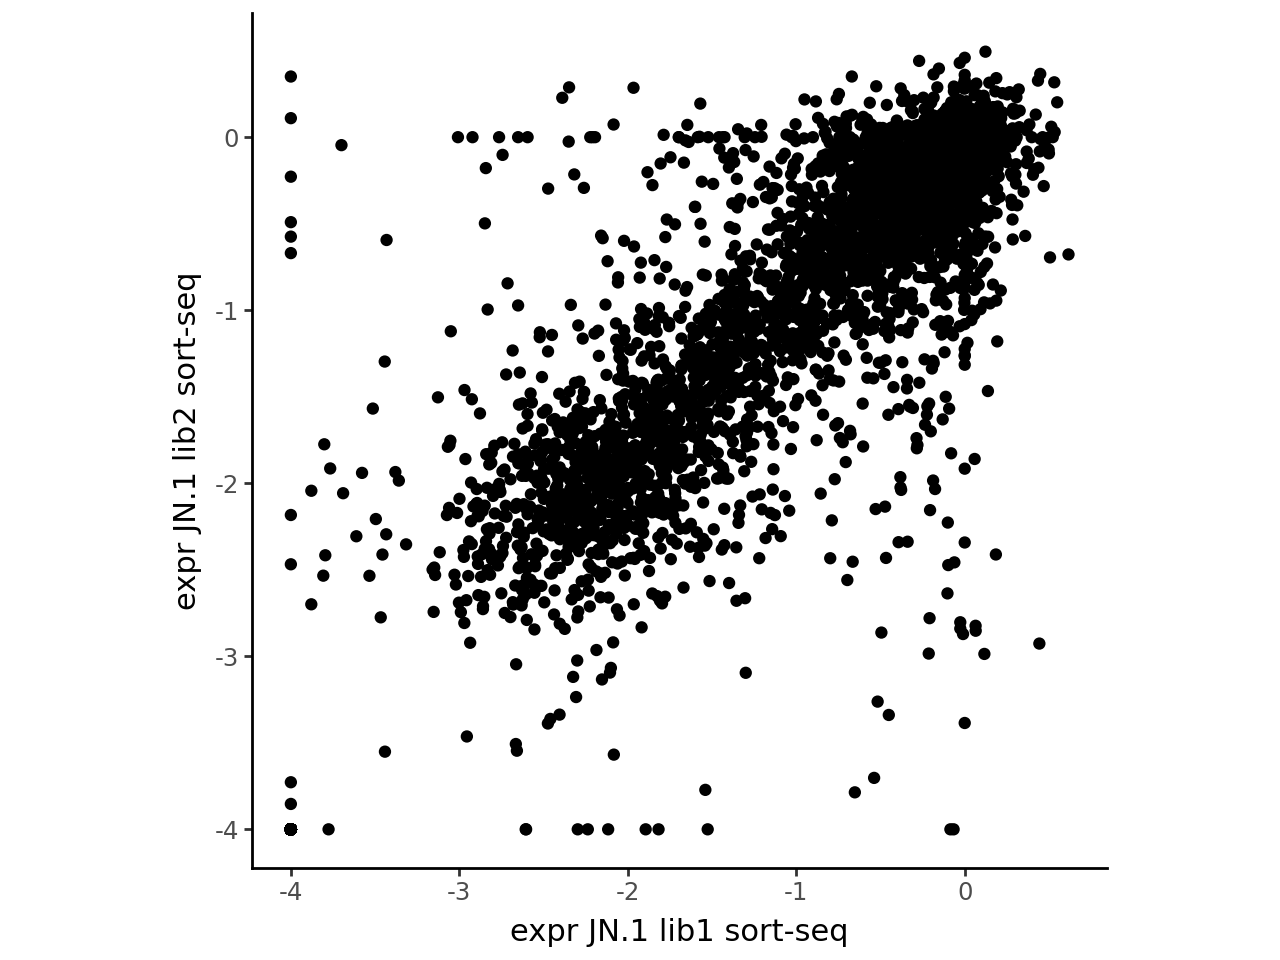


3424
PearsonRResult(statistic=0.9013268772634815, pvalue=0.0)


/tmp/ipykernel_4488/987445333.py:15: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/gshare/xielab/jianfc/miniforge3/envs/antibody/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 772 rows containing missing values.


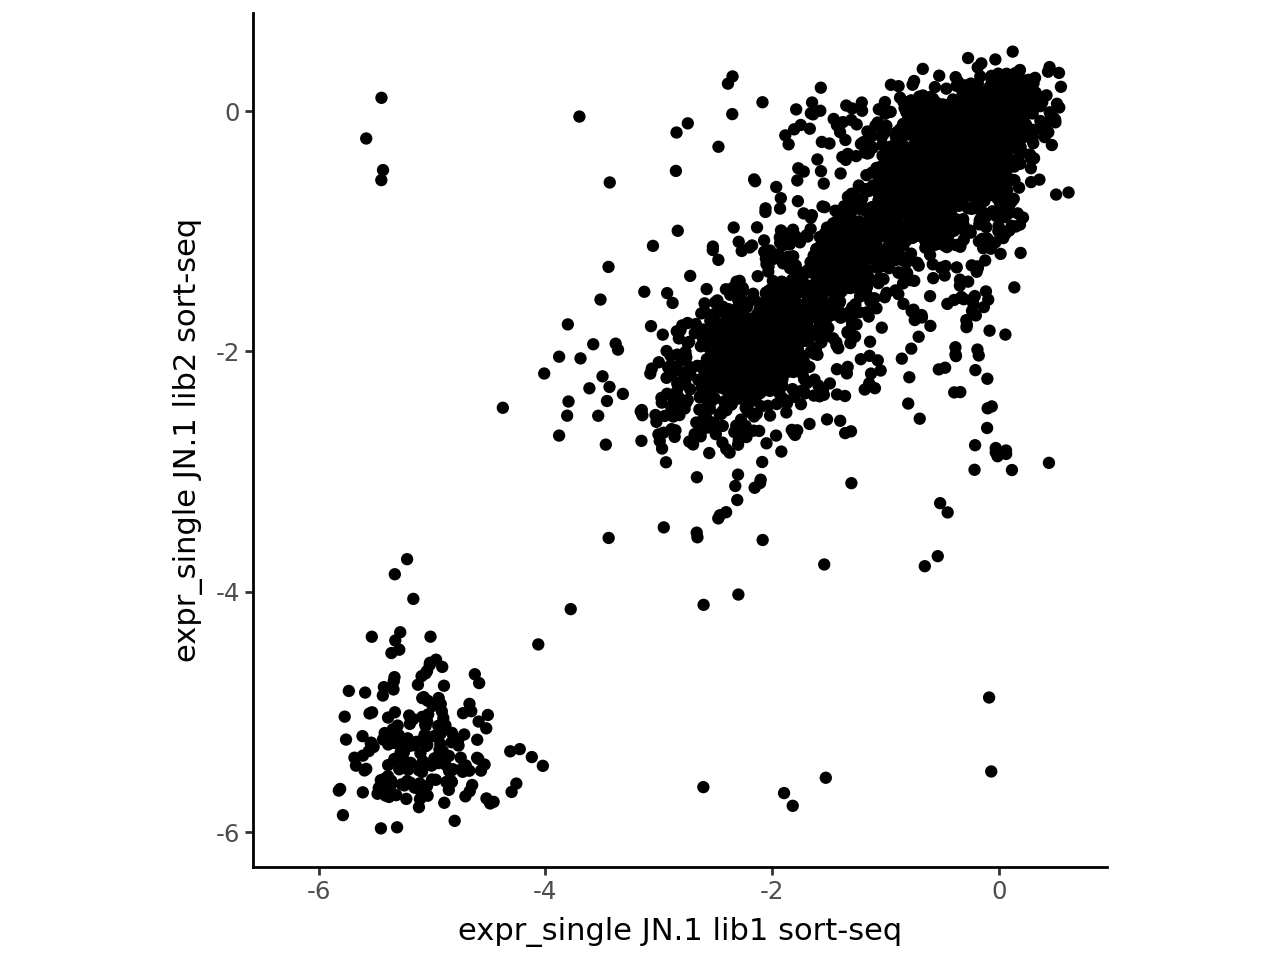

In [28]:
from scipy.stats import pearsonr
from plotnine import *
import pandas as pd
df1 = pd.read_csv('../data/DMS/RBD_expression/JN1lib1/_single_mutation_effects.csv')
df2 = pd.read_csv('../data/DMS/RBD_expression/JN1lib2/_single_mutation_effects.csv')

df_merge = df1.merge(df2, how='outer', on=['wildtype','site','mutant','mutation_st','mutation'])
print(len(df_merge))

for col in ['expr', 'expr_single']:
    _ = df_merge[[f'{col}_x',f'{col}_y']].dropna()
    print(len(_))
    print(pearsonr(_[f'{col}_x'],_[f'{col}_y']))

    print(
        ggplot(df_merge,aes(x=f'{col}_x',y=f'{col}_y'))+geom_point()+theme_classic()+theme(aspect_ratio=1.0)+xlab(f'{col} JN.1 lib1 sort-seq')+ylab(f'{col} JN.1 lib2 sort-seq')#+xlim(-4,1)+ylim(-4,1)
)


In [34]:
# combine replicates
# drop inconsistent results (abs(lib1-lib2) > 1.0) and mutations that are not detected in both libraries

def check_drop(rep1, rep2):
    if abs(rep1-rep2) > 1.0 or np.isnan(rep1) or np.isnan(rep2):
        # return True
        return False
    else:
        return False

df_merge_out = df_merge.drop(columns=['library_x', 'library_y']).rename(
    columns = {
        'expr_x': 'expr_lib1', 'expr_y': 'expr_lib2',
        'expr_model_x': 'expr_model_lib1', 'expr_model_y': 'expr_model_lib2',
        'expr_single_x': 'expr_single_lib1', 'expr_single_y': 'expr_single_lib2',
    }
).assign(
    expr_model_avg = lambda x: np.mean(x[['expr_model_lib1', 'expr_model_lib2']], axis=1),
    expr_single_avg = lambda x: np.mean(x[['expr_single_lib1', 'expr_single_lib2']], axis=1),
).assign(
    expr_avg = lambda x: [
        max(cutoff_low, np.nan if check_drop(x['expr_lib1'][i], x['expr_lib2'][i]) else (x['expr_single_avg'][i] if not np.isnan(x['expr_single_avg'][i]) else x['expr_model_avg'][i])) for i in x.index
    ]
).sort_values(['site','mutation'])
df_merge_out.to_csv("../data/DMS/RBD_expression/_JN1_DMS_single_mutation_expr.csv", index=None)